<span style="font-size: 48px; font-weight: bold;">Algorytm Algorytm EA testowany na zbiorze Fashion-MNIST</span>

Spis treści

- [1](#1)- Zainstalowanie wymaganych pakietów
- [2](#2) - Zaimportowanie bibliotek np.numpy, keras, skopt, tensorflow
- [3](#3) - Załadowanie danych
- [4](#4) - Ocena zbalansowania zbioru
- [5](#5) - Normalizacja danych
- [6](#6)- Zdefiniowanie CNN
- [7](#7) - Zdefiniowanie przestrzeni hiperparametrów i umieszczenie hiperparametrów na liście
- [8](#8) - Zdefiniowa funkcji celu
- [9](#9) - Zdefiniowanie parametrów startowych
- [10](#10) - Wykonanie proces optymalizacji bayesowskiej za pomocą funkcji `gp_minimize`
- [11](#11) - Wyświetlenie najlepszych wyników
- [12](#12) - Wykres konwergencji
- [13](#13) - Wykres wartość funkcji celu w każdej iteracji
- [14](#14) - Wykres plot_objective
- [15](#15) - Wykres plot evaluations
- [16](#16) - Macierz pomyłek
- [17](#17) - Ocena modelu na zbiorze testowym

### <a name='1'></a> 1. Zainstalowanie wymaganych pakietów

In [21]:
# !pip install scikit-learn
# !pip install scikit-optimize
# !pip install keras
# !pip install numpy

### <a name="2"></a> 2. Zaimportowanie bibliotek np.numpy, keras, skopt, tensorflow

In [22]:
import itertools
import random
import inspect
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from keras.utils import to_categorical
from keras.models import Sequential, load_model
from keras.layers import Dense, Flatten, Conv2D, MaxPool2D,MaxPooling2D
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau

from skopt import gp_minimize
from skopt.space import Real, Categorical, Integer
from skopt.plots import plot_convergence
from skopt.plots import plot_objective, plot_evaluations
from skopt.utils import use_named_args

import tensorflow as tf
from sklearn.utils import check_random_state
from skopt.utils import cook_estimator
from skopt.utils import normalize_dimensions
from skopt import Optimizer
from sklearn.utils import check_random_state

In [23]:
import time


### <a name="3"></a> 3.Załadowanie danych


In [24]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

In [25]:
type(y_train)

numpy.ndarray

### <a name="4"></a> 4.Ocena zbalansowania zbioru

Text(0, 0.5, 'Number of images')

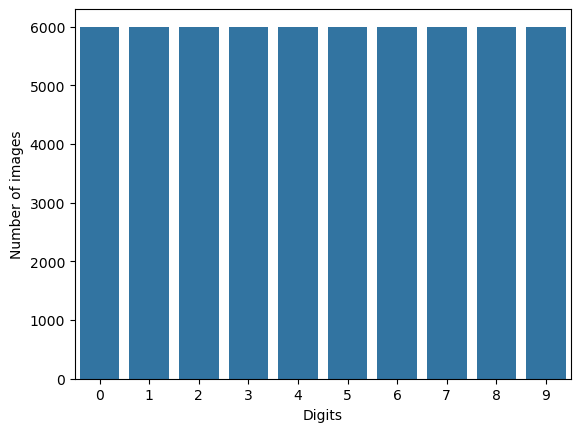

In [26]:
g = sns.countplot(x=y_train)
plt.xlabel('Digits')
plt.ylabel('Number of images')

### <a name="5"></a> 5. Normalizacja danych

In [27]:
X_train = X_train / 255
X_test = X_test / 255

X_train = pd.DataFrame(X_train.reshape(X_train.shape[0], -1))
X_test = pd.DataFrame(X_test.reshape(X_test.shape[0], -1))
X_train = X_train.values.reshape(-1,28,28,1)
X_test = X_test.values.reshape(-1,28,28,1)
y_train = pd.DataFrame(y_train, columns=['label'])
y_test = pd.DataFrame(y_test, columns=['label'])

y_train = to_categorical(y_train, num_classes = 10)
y_test = to_categorical(y_test, num_classes = 10)

In [28]:
type(X_train)

numpy.ndarray

### <a name="6"></a> 6.Zdefiniowanie CNN

In [29]:
def create_cnn(
    learning_rate,
    num_dense_layers,
    num_dense_nodes,
    activation,
):
    """
    Hiperparametry:
    learning_rate: Współczynnik uczenia dla optymalizatora.
    num_dense_layers: Liczba warstw gęstych.
    num_dense_nodes: Liczba neuronów w każdej warstwie gęstej.
    activation: Funkcja aktywacji dla wszystkich warstw.
    """

    model = Sequential()

    model.add(Conv2D(kernel_size=5, strides=1, filters=32, padding='same',
                     activation=activation, name='layer_conv1'))
    model.add(MaxPool2D(pool_size=2, strides=2))
    

    model.add(Conv2D(kernel_size=5, strides=1, filters=64, padding='same',
                     activation=activation, name='layer_conv2'))
    model.add(MaxPool2D(pool_size=2, strides=2))

    model.add(Flatten()) 

    
    for i in range(num_dense_layers):

        model.add(Dense(num_dense_nodes,
                        activation=activation,
                        ))


    model.add(Dense(10, activation='sigmoid')) 

    optimizer = Adam(learning_rate=learning_rate)

    model.compile(optimizer=optimizer,
                  loss='binary_crossentropy', 
                  metrics=['accuracy'])

    return model

### <a name="7"></a> 7.Zdefiniowanie przestrzeni hiperparametrów i umieszczenie hiperparametrów na liście

In [30]:
path_best_model = 'cnn_model.h5'

best_accuracy = 0
random_state = None

param_grid = {
    "learning_rate": (1e-6, 1e-2),
    "num_dense_layers": (1, 5),
    "num_dense_nodes": (10, 500),
    "activation": ["relu", "sigmoid"]
}

In [31]:
class Individual():
    """Klasa reprezentująca pojedyńczego osobnika,
        przechowuje wszystkie jego cechy"""
    def __init__(self,
                 learning_rate = None,
                 num_dense_layers =None,
                 num_dense_nodes = None,
                 activation = None,
                 num_conv_layers = None,
                 filter_size = None,
                 kernel_size = None,
                 evaluate_ind=-1
                 ):
        self.learning_rate = learning_rate
        self.num_dense_layers = num_dense_layers
        self.num_dense_nodes = num_dense_nodes
        self.activation = activation
        self.num_conv_layers = num_conv_layers
        self.filter_size = filter_size
        self.kernel_size = kernel_size
        self.evaluate_ind = evaluate_ind
        super().__init__()
    def __repr__(self):
        """Reprezentacja obiektu zawierająca wszystkie jego cechy."""
        return (
            f"Individual("
            f"learning_rate={self.learning_rate}, "
            f"num_dense_layers={self.num_dense_layers}, "
            f"num_dense_nodes={self.num_dense_nodes}, "
            f"activation={self.activation}, "
            f"num_conv_layers={self.num_conv_layers}, "
            f"filter_size={self.filter_size}, "
            f"kernel_size={self.kernel_size}, "
            f"evaluate_ind={self.evaluate_ind})"
        )

In [32]:

def mutation(individual: Individual, param_grid, p_m_con=0.3):
    """Metoda odpowiedzialna za mutacje"""

    # Pobranie wszystkich atrybutów, które nie są None
    non_none_attributes = {
        attr: value for attr, value in vars(individual).items() if value is not None
    }
    # Mutacja każdej zmiennej
    mutated_attributes = {}
    for attr, value in non_none_attributes.items():
        if attr in param_grid:  # Jeśli zmienna istnieje w param_grid
            if isinstance(param_grid[attr], tuple):  # Mutujemy tylko liczby
                mutated_attributes[attr] = mutate_variable(value, attr, param_grid, p_m_con=p_m_con)
            elif isinstance(param_grid[attr], list):  # Zmienna kategoryczna - bez mutacji
                mutated_attributes[attr] = value  # Przepisanie bez zmian
        else:
            mutated_attributes[attr] = value  # Przepisujemy wartości spoza param_grid bez zmian

    new_individual = Individual(**mutated_attributes)
    return new_individual


def mutate_variable(variable, variable_name, param_grid, length=30, p_m_con=0.3):
    """Metoda odpowiedzialna za mutację zmiennych ciągłych"""
    mutant_gene = variable
    if variable_name not in param_grid:
        raise ValueError(f"Zmienna '{variable_name}' nie istnieje w param_grid.")
    param = param_grid[variable_name]

    if isinstance(param, tuple):
        lower_bound, upper_bound = param
        # Obliczenie precyzji
        precision = (upper_bound - lower_bound) / ((2 ** length) - 1)
    else:
        raise ValueError(f"Zmienna '{variable_name}' nie jest numeryczna i nie może być mutowana.")

    #mutacja zmiennej ciągłej
    mutant_gene = encode_variable(mutant_gene,precision, lower_bound,length)
    for idx in range(len(mutant_gene)):
        if np.random.rand() < p_m_con:  # Prawdopodobieństwo mutacji
            if mutant_gene[idx] == 0:
                mutant_gene[idx] = 1
            else:
                mutant_gene[idx] = 0
    mutant_gene = decode_individual(mutant_gene, length,precision,lower_bound)
    if isinstance(variable, int):
        mutant_gene = int(round(mutant_gene))
    return mutant_gene

def encode_variable(value, precision, lower_bound, length):
    """Zakodowanie liczby do postaci bitowej"""
    shifted_value = (value - lower_bound) / precision
    int_value = int(round(shifted_value))
    binary_representation = [int(bit) for bit in bin(int_value)[2:].zfill(length)]

    return binary_representation

def decode_individual(individual, length, precision, lower_bound):
    """Dekoduje zakodowaną tablicę bitową na wartość rzeczywistą."""
    num_sum = sum(individual[-(i + 1)] * (2 ** i) for i in range(length))
    decoded_value = (num_sum * precision) + lower_bound
    return decoded_value


def crossover(parent_1: Individual, parent_2: Individual, param_grid, length=20):
    """Krzyżowanie dwóch osobników z uwzględnieniem typów cech i obliczaniem wartości `evaluate_ind`."""

    child_1_attributes = {}
    child_2_attributes = {}
    toggle = True  # Flaga do naprzemiennego przydzielania wartości cech kategorycznych

    for attr in param_grid:
        # Pomiń `evaluate_ind` w krzyżowaniu
        if attr == "evaluate_ind":
            continue

        # Pobierz wartości cechy dla obu rodziców
        value_1 = getattr(parent_1, attr)
        value_2 = getattr(parent_2, attr)

        # Jeśli cecha jest None, pomijamy ją
        if value_1 is None or value_2 is None:
            continue

        # Obsługa cech numerycznych
        if isinstance(param_grid[attr], tuple):  # Zakres wartości numerycznych
            lower_bound, upper_bound = param_grid[attr]
            precision = (upper_bound - lower_bound) / ((2 ** length) - 1)

            # Zakodowanie wartości
            binary_1 = encode_variable(value_1, precision, lower_bound, length)
            binary_2 = encode_variable(value_2, precision, lower_bound, length)

            # One-point crossover
            crossover_point = random.randint(1, length - 14)
            child_binary_1 = binary_1[:crossover_point] + binary_2[crossover_point:]
            child_binary_2 = binary_2[:crossover_point] + binary_1[crossover_point:]

            # Dekodowanie wartości
            child_value_1 = decode_individual(child_binary_1, length, precision, lower_bound)
            child_value_2 = decode_individual(child_binary_2, length, precision, lower_bound)

            # Konwersja na int dla cech takich jak `num_dense_layers`
            if attr in ['num_dense_layers', 'num_dense_nodes', 'num_conv_layers']:
                child_value_1 = int(round(child_value_1))
                child_value_2 = int(round(child_value_2))

            # Przypisanie wartości do atrybutów
            child_1_attributes[attr] = child_value_1
            child_2_attributes[attr] = child_value_2

        # Obsługa cech kategorycznych
        elif isinstance(param_grid[attr], list):  # Lista kategoryczna
            if toggle:
                child_1_attributes[attr] = value_1
                child_2_attributes[attr] = value_2
            else:
                child_1_attributes[attr] = value_2
                child_2_attributes[attr] = value_1
            toggle = not toggle  # Zmiana flagi dla naprzemienności

    # Tworzenie potomków bez `evaluate_ind`
    child_1 = Individual(**child_1_attributes)
    child_2 = Individual(**child_2_attributes)

    return child_1, child_2

def tournament_selection(population, tournament_size=2):

    # Wybierz pierwszego rodzica
    candidates_1 = random.sample(population, tournament_size)
    parent_1 = max(candidates_1, key=lambda individual: individual.evaluate_ind)

    # Wybierz drugiego rodzica, upewniając się, że jest różny od pierwszego
    while True:
        candidates_2 = random.sample(population, tournament_size)
        parent_2 = max(candidates_2, key=lambda individual: individual.evaluate_ind)
        if parent_2 != parent_1:
            break
    return parent_1, parent_2


def individual_to_list(individual, space):
    """
    Przekształca obiekt `Individual` na listę wartości odpowiadającą przestrzeni `space`.
    Tylko cechy zdefiniowane w `space` zostaną uwzględnione.
    """
    # Wyciągnij nazwy parametrów ze space
    space_names = [dim.name for dim in space]

    # Zmapuj parametry individual do listy zgodnej z przestrzenią space
    return [getattr(individual, name) for name in space_names]

class GeneticAlgorithm:
    def __init__(self, param_grid, iteration=9, mutation_probability=0.2, population_size = 10):
        self.iteration = iteration
        self.list_num_iter = []
        self.best_solution_iter = []
        self.solution_iter = []
        self.param_grid = param_grid
        self.mutation_probability = mutation_probability
        self.path_best_model = 'cnn_model.h5'
        self.best_accuracy = 0
        self.best_hyperparameters = None
        self.solution_iter_genotype = []
        self.population_size=population_size
    

    def objective(self, learning_rate, num_dense_layers, num_dense_nodes, activation):
        """Funkcja celu, oceniająca model."""
        model = create_cnn(
            learning_rate=learning_rate,
            num_dense_layers=num_dense_layers,
            num_dense_nodes=num_dense_nodes,
            activation=activation
        )

        learning_rate_reduction = ReduceLROnPlateau(
            monitor='val_accuracy',
            patience=2,
            verbose=1,
            factor=0.5,
            min_lr=0.00001
        )

        history = model.fit(
            x=X_train,
            y=y_train,
            epochs=5,
            batch_size=32,
            validation_split=0.1,
            callbacks=[learning_rate_reduction]
        )

        accuracy = history.history['val_accuracy'][-1]

            # Aktualizacja najlepszych wyników, jeśli nowa dokładność jest lepsza
        if accuracy > self.best_accuracy:
            model.save(self.path_best_model)
            self.best_accuracy = accuracy
            self.best_hyperparameters = {
                "learning_rate": learning_rate,
                "num_dense_layers": num_dense_layers,
                "num_dense_nodes": num_dense_nodes,
                "activation": activation
            }

            del model

        return accuracy


    def first_generate_population(self,param_grid):
        population = []
        for _ in range(self.population_size):
            random_params = {}
            for param, values in param_grid.items():
                if isinstance(values, tuple):  # Zakres wartości liczbowych
                    random_params[param] = random.uniform(*values)
                    if isinstance(values[0], int):  # Jeśli to liczba całkowita
                        random_params[param] = int(round(random_params[param]))
                elif isinstance(values, list):  # Lista kategorii
                    random_params[param] = random.choice(values)
            individual = Individual(**random_params)
            # Oblicz `evaluate_ind` dla osobnika
            objective_args = inspect.signature(self.objective).parameters.keys()
            hyperparameters = {
                attr: value for attr, value in vars(individual).items() if attr in objective_args
            }
            individual.evaluate_ind = self.objective(**hyperparameters)
            population.append(individual)
            self.best_solution_iter.append(self.best_accuracy)
        return population
    
    

    def define_search_space_around_individual(self, individual):
        search_space = [
            Real(
                low=max(1e-6, individual.learning_rate - 1e-4),
                high=min(1e-2, individual.learning_rate + 1e-4),
                prior='log-uniform',
                name='learning_rate'
            ),
            Integer(
                low=max(1, individual.num_dense_layers - 1),
                high=individual.num_dense_layers + 1,
                name='num_dense_layers'
            ),
            Integer(
                low=max(10, individual.num_dense_nodes - 20),
                high=individual.num_dense_nodes + 20,
                name='num_dense_nodes'
            )
            # Usuń stałe punkty (np. num_conv_layers, filter_size, kernel_size)
        ]
        return search_space

    def point_to_individual(self, point, space, best_individual=None):
        """
        Konwertuje listę/array `point` (z `optimizer.ask()`) na obiekt `Individual`.
        Dla atrybutów, których nie ma w `space`, używamy np. wartości z `best_individual`.
        """
        # Nazwy parametrów, które faktycznie bierzemy z `space`
        space_names = [dim.name for dim in space]

        # Zrobienie słownika z parametrami, które *są* w space
        param_dict = dict(zip(space_names, point))

        # Jeśli mamy `best_individual`, to dopełnij brakujące parametry
        if best_individual is not None:
            all_attrs = [
                "learning_rate",
                "num_dense_layers",
                "num_dense_nodes",
                "activation",
                "evaluate_ind"
                # cokolwiek jeszcze Individual może mieć
            ]
            for attr in all_attrs:
                # jeżeli w param_dict nie ma klucza `attr`, weź go z best_individual
                if attr not in param_dict:
                    param_dict[attr] = getattr(best_individual, attr, None)
        
        # Teraz tworzymy obiekt Individual
        return Individual(**param_dict)
        
    
    def run(self):

        # Inicjalizacja populacji
        population = self.first_generate_population(self.param_grid)

        self.solution_iter = [individual.evaluate_ind for individual in population]
        self.solution_iter_genotype = [vars(individual) for individual in population]
        self.list_num_iter = [i for i in range(1,(self.iteration+1)*self.population_size+1 + (self.iteration-1)*10)]
        iteration = 1
        bayesian_flag = False
        for i in range(self.iteration):

            new_population = []
            # Generowanie nowej populacji
            for j in range(self.population_size//2):

                parent_1, parent_2 = tournament_selection(population)
                child_1, child_2 = crossover(parent_1, parent_2, self.param_grid)

                if random.random() <= self.mutation_probability:
                    child_1 = mutation(child_1, self.param_grid)

                # Obliczenie oceny dla child_1
                objective_args = inspect.signature(self.objective).parameters.keys()
                hyperparameters_1 = {
                    attr: value for attr, value in vars(child_1).items()
                    if attr in objective_args
                }
                child_1.evaluate_ind = self.objective(**hyperparameters_1)

                if random.random() <= self.mutation_probability:
                    child_2 = mutation(child_2, param_grid)

                # Obliczenie oceny dla child_2
                hyperparameters_2 = {
                    attr: value for attr, value in vars(child_2).items()
                    if attr in objective_args
                }
                child_2.evaluate_ind = self.objective(**hyperparameters_2)

                #aktualizacja zmiennych wewnętrznych
                #dodanie osobników do populacji i zaktualizowanie best_accuracy
                new_population.append(child_1)
                self.best_solution_iter.append(self.best_accuracy)
                new_population.append(child_2)
                self.best_solution_iter.append(self.best_accuracy)


                #dodanie accuracy dziecka do listy i dodanie hiperparametrów 
                self.solution_iter.append(child_1.evaluate_ind)
                self.solution_iter_genotype.append(vars(child_1))
                self.solution_iter.append(child_2.evaluate_ind)
                self.solution_iter_genotype.append(vars(child_2))

            population = new_population
            if bayesian_flag:
                self.best_individual = max(new_population, key=lambda individual: individual.evaluate_ind)

                space = self.define_search_space_around_individual(self.best_individual)
                
                random_state = None
                rng = check_random_state(random_state)
                space = normalize_dimensions(space)
                base_estimator = None
                if base_estimator is None:
                        base_estimator = cook_estimator(
                            "GP", space=space, random_state=rng.randint(0, np.iinfo(np.int32).max),
                            noise="gaussian")

                acq_optimizer_kwargs = {
                        "n_points": 10000, "n_restarts_optimizer": 5,
                        "n_jobs": 1}
                acq_func_kwargs = {"xi": 0.01, "kappa": 1.96}                

            
                optimizer = Optimizer(space, base_estimator = base_estimator,
                            n_initial_points=4,
                            initial_point_generator="random",
                            n_jobs=1,
                            acq_func="EI", acq_optimizer="lbfgs",
                            random_state=rng,
                            model_queue_size=None,
                            acq_optimizer_kwargs=acq_optimizer_kwargs,
                            acq_func_kwargs=acq_func_kwargs)




                optimizer.tell(individual_to_list(self.best_individual,space), -self.best_individual.evaluate_ind)
                bayes_candidates = []
                for n in range(10):
                    next_x = optimizer.ask()
                    # Stałe parametry z best_individual
                    static_params = [
                        self.best_individual.activation
                    ]

                    # Konkatenacja dynamicznych i stałych parametrów
                    point_rate = next_x + static_params
                    self.best_solution_iter.append(self.best_accuracy)
                    next_y = - self.objective(*point_rate)
                    optimizer.tell(next_x, next_y)
                    next_x = self.point_to_individual(next_x,space,self.best_individual)
                    next_x.evaluate_ind = - next_y
                    self.solution_iter_genotype.append(next_x) 
                    bayes_candidates.append(next_x)
                    self.solution_iter.append(-next_y) 



                best_bayes_candidate = max(bayes_candidates, key=lambda c: c.evaluate_ind)

                if best_bayes_candidate.evaluate_ind > self.best_individual.evaluate_ind:
                    idx = new_population.index(self.best_individual)
                    new_population[idx] = best_bayes_candidate

            
            bayesian_flag = True
            iteration += 1
        print("Najlepsze hiperparametry:", self.best_hyperparameters)
        print("Najlepsza dokładność:", self.best_accuracy)
        self.save_to_files()

    def save_to_files(self):
        """Zapisuje dane iteracji do plików CSV."""
        # Przygotowanie danych do pierwszego pliku
        solution_data = {
            "Iteration": self.list_num_iter,
            "Solutions": self.solution_iter
        }
        df_solutions = pd.DataFrame(solution_data)
        df_solutions.to_csv("solutions.csv", index=False)
        print("Zapisano plik: solutions.csv")

        genotype_data = []

        for i, genotype_dict in enumerate(
                self.solution_iter_genotype):  # Zakładamy, że self.solution_iter_genotype to lista słowników
            if isinstance(genotype_dict, dict):  # Upewnij się, że to słownik
                genotype_data.append({"Iteration": i + 1, **genotype_dict})
            else:
                print(f"Nieprawidłowy genotyp: {genotype_dict}")

        print("Wynik genotype_data:", genotype_data)

        df_genotypes = pd.DataFrame(genotype_data)
        df_genotypes.to_csv("genotypes.csv", index=False)
        print("Zapisano plik: genotypes.csv")



        # Przygotowanie danych do drugiego pliku
        best_solution_data = {
            "Iteration": self.list_num_iter,
            "Best Accuracy": self.best_solution_iter
        }
        df_best_solutions = pd.DataFrame(best_solution_data)
        df_best_solutions.to_csv("best_solutions.csv", index=False)
        print("Zapisano plik: best_solutions.csv")


if __name__ == "__main__":

    genetic_algorithm = GeneticAlgorithm(
        iteration = 5,
        param_grid = param_grid,
        mutation_probability=0.3,
        population_size=10
    )
    start_time = time.time()
    genetic_algorithm.run()
    end_time = time.time()

    execution_time = end_time - start_time
    print(f"Czas wykonania funkcji run: {execution_time:.2f} sekund")


Epoch 1/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.7444 - loss: 0.1223 - val_accuracy: 0.8907 - val_loss: 0.0539 - learning_rate: 0.0025
Epoch 2/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.8974 - loss: 0.0525 - val_accuracy: 0.8985 - val_loss: 0.0517 - learning_rate: 0.0025
Epoch 3/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.9105 - loss: 0.0454 - val_accuracy: 0.9073 - val_loss: 0.0488 - learning_rate: 0.0025
Epoch 4/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.9178 - loss: 0.0409 - val_accuracy: 0.8993 - val_loss: 0.0493 - learning_rate: 0.0025
Epoch 5/5
1682/1688 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9261 - loss: 0.0367
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0012577198212966323.
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.9261 - loss: 0.0367 - val_accuracy: 0.9058 - val_loss: 0.0525 - learning_rate: 0.0025


Epoch 1/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 19s 10ms/step - accuracy: 0.0978 - loss: 0.3433 - val_accuracy: 0.0942 - val_loss: 0.3260 - learning_rate: 0.0078
Epoch 2/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 17s 10ms/step - accuracy: 0.0983 - loss: 0.3257 - val_accuracy: 0.0942 - val_loss: 0.3263 - learning_rate: 0.0078
Epoch 3/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 17s 10ms/step - accuracy: 0.1035 - loss: 0.3256 - val_accuracy: 0.1003 - val_loss: 0.3255 - learning_rate: 0.0078
Epoch 4/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 17s 10ms/step - accuracy: 0.1000 - loss: 0.3255 - val_accuracy: 0.0925 - val_loss: 0.3254 - learning_rate: 0.0078
Epoch 5/5
1684/1688 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.0996 - loss: 0.3254
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0039038308896124363.
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 17s 10ms/step - accuracy: 0.0996 - loss: 0.3254 - val_accuracy: 0.0973 - val_loss: 0.3255 - learning_rate: 0.0078
Epoch 1/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 16s 9ms/step - accuracy: 0.100

Epoch 1/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.7631 - loss: 0.1207 - val_accuracy: 0.8758 - val_loss: 0.0598 - learning_rate: 0.0076
Epoch 2/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.8820 - loss: 0.0572 - val_accuracy: 0.8855 - val_loss: 0.0563 - learning_rate: 0.0076
Epoch 3/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.8931 - loss: 0.0528 - val_accuracy: 0.8862 - val_loss: 0.0568 - learning_rate: 0.0076
Epoch 4/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.9021 - loss: 0.0496 - val_accuracy: 0.8932 - val_loss: 0.0554 - learning_rate: 0.0076
Epoch 5/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.9075 - loss: 0.0463 - val_accuracy: 0.8920 - val_loss: 0.0581 - learning_rate: 0.0076
Epoch 1/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.0982 - loss: 0.3583 - val_accuracy: 0.1050 - val_loss: 0.3255 - learning_rate: 0.0025
Epoch 2/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.0963 - l

Epoch 1/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 16s 9ms/step - accuracy: 0.7826 - loss: 0.1056 - val_accuracy: 0.8767 - val_loss: 0.0595 - learning_rate: 0.0026
Epoch 2/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 15s 9ms/step - accuracy: 0.8972 - loss: 0.0511 - val_accuracy: 0.8967 - val_loss: 0.0537 - learning_rate: 0.0026
Epoch 3/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 15s 9ms/step - accuracy: 0.9144 - loss: 0.0426 - val_accuracy: 0.8993 - val_loss: 0.0499 - learning_rate: 0.0026
Epoch 4/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 15s 9ms/step - accuracy: 0.9251 - loss: 0.0371 - val_accuracy: 0.9093 - val_loss: 0.0467 - learning_rate: 0.0026
Epoch 5/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 15s 9ms/step - accuracy: 0.9331 - loss: 0.0337 - val_accuracy: 0.9083 - val_loss: 0.0506 - learning_rate: 0.0026
Epoch 1/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 17s 9ms/step - accuracy: 0.7660 - loss: 0.1143 - val_accuracy: 0.8873 - val_loss: 0.0560 - learning_rate: 0.0026
Epoch 2/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 15s 9ms/step - accuracy: 0.8964 - l

Epoch 1/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 17s 9ms/step - accuracy: 0.7647 - loss: 0.1116 - val_accuracy: 0.8925 - val_loss: 0.0520 - learning_rate: 0.0026
Epoch 2/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 15s 9ms/step - accuracy: 0.8972 - loss: 0.0509 - val_accuracy: 0.9030 - val_loss: 0.0495 - learning_rate: 0.0026
Epoch 3/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 15s 9ms/step - accuracy: 0.9106 - loss: 0.0435 - val_accuracy: 0.9057 - val_loss: 0.0471 - learning_rate: 0.0026
Epoch 4/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 15s 9ms/step - accuracy: 0.9217 - loss: 0.0380 - val_accuracy: 0.9062 - val_loss: 0.0477 - learning_rate: 0.0026
Epoch 5/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 15s 9ms/step - accuracy: 0.9309 - loss: 0.0341 - val_accuracy: 0.9092 - val_loss: 0.0499 - learning_rate: 0.0026
Epoch 1/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 16s 9ms/step - accuracy: 0.7751 - loss: 0.1058 - val_accuracy: 0.8747 - val_loss: 0.0635 - learning_rate: 0.0025
Epoch 2/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 15s 9ms/step - accuracy: 0.8987 - l

Epoch 1/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.7761 - loss: 0.1063 - val_accuracy: 0.8958 - val_loss: 0.0509 - learning_rate: 0.0022
Epoch 2/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.9000 - loss: 0.0491 - val_accuracy: 0.8992 - val_loss: 0.0496 - learning_rate: 0.0022
Epoch 3/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.9155 - loss: 0.0411 - val_accuracy: 0.9038 - val_loss: 0.0511 - learning_rate: 0.0022
Epoch 4/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.9275 - loss: 0.0355 - val_accuracy: 0.9075 - val_loss: 0.0499 - learning_rate: 0.0022
Epoch 5/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.9347 - loss: 0.0323 - val_accuracy: 0.9105 - val_loss: 0.0467 - learning_rate: 0.0022
Epoch 1/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - accuracy: 0.7788 - loss: 0.1061 - val_accuracy: 0.8772 - val_loss: 0.0629 - learning_rate: 0.0021
Epoch 2/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.8973 - l

Epoch 1/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.7753 - loss: 0.1057 - val_accuracy: 0.8807 - val_loss: 0.0581 - learning_rate: 0.0023
Epoch 2/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.8976 - loss: 0.0503 - val_accuracy: 0.8888 - val_loss: 0.0583 - learning_rate: 0.0023
Epoch 3/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.9151 - loss: 0.0416 - val_accuracy: 0.9075 - val_loss: 0.0473 - learning_rate: 0.0023
Epoch 4/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.9256 - loss: 0.0366 - val_accuracy: 0.8997 - val_loss: 0.0554 - learning_rate: 0.0023
Epoch 5/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9360 - loss: 0.0321
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.001128458185121417.
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.9360 - loss: 0.0321 - val_accuracy: 0.9020 - val_loss: 0.0518 - learning_rate: 0.0023
Epoch 1/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.7975 - los

Epoch 1/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 16s 9ms/step - accuracy: 0.7880 - loss: 0.1002 - val_accuracy: 0.8867 - val_loss: 0.0560 - learning_rate: 0.0032
Epoch 2/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 15s 9ms/step - accuracy: 0.8910 - loss: 0.0531 - val_accuracy: 0.8900 - val_loss: 0.0543 - learning_rate: 0.0032
Epoch 3/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 15s 9ms/step - accuracy: 0.9064 - loss: 0.0462 - val_accuracy: 0.8880 - val_loss: 0.0607 - learning_rate: 0.0032
Epoch 4/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 15s 9ms/step - accuracy: 0.9178 - loss: 0.0410 - val_accuracy: 0.9063 - val_loss: 0.0498 - learning_rate: 0.0032
Epoch 5/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 14s 9ms/step - accuracy: 0.9280 - loss: 0.0361 - val_accuracy: 0.9055 - val_loss: 0.0507 - learning_rate: 0.0032
Epoch 1/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.7861 - loss: 0.1060 - val_accuracy: 0.8773 - val_loss: 0.0609 - learning_rate: 0.0085
Epoch 2/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.8885 - l

Epoch 1/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.7837 - loss: 0.1074 - val_accuracy: 0.8808 - val_loss: 0.0627 - learning_rate: 0.0012
Epoch 2/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.9012 - loss: 0.0495 - val_accuracy: 0.8988 - val_loss: 0.0494 - learning_rate: 0.0012
Epoch 3/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.9188 - loss: 0.0413 - val_accuracy: 0.9085 - val_loss: 0.0440 - learning_rate: 0.0012
Epoch 4/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.9309 - loss: 0.0347 - val_accuracy: 0.9122 - val_loss: 0.0461 - learning_rate: 0.0012
Epoch 5/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.9424 - loss: 0.0293 - val_accuracy: 0.9178 - val_loss: 0.0440 - learning_rate: 0.0012
Epoch 1/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.7789 - loss: 0.1090 - val_accuracy: 0.8928 - val_loss: 0.0530 - learning_rate: 0.0012
Epoch 2/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.9001 - l

Epoch 1/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.7863 - loss: 0.1064 - val_accuracy: 0.8908 - val_loss: 0.0540 - learning_rate: 0.0014
Epoch 2/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.9016 - loss: 0.0493 - val_accuracy: 0.9080 - val_loss: 0.0473 - learning_rate: 0.0014
Epoch 3/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.9181 - loss: 0.0412 - val_accuracy: 0.9003 - val_loss: 0.0491 - learning_rate: 0.0014
Epoch 4/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.9300 - loss: 0.0355 - val_accuracy: 0.9212 - val_loss: 0.0416 - learning_rate: 0.0014
Epoch 5/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.9454 - loss: 0.0285 - val_accuracy: 0.9177 - val_loss: 0.0423 - learning_rate: 0.0014
Epoch 1/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.7644 - loss: 0.1108 - val_accuracy: 0.8923 - val_loss: 0.0522 - learning_rate: 0.0014
Epoch 2/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.8996 - l

Epoch 1/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - accuracy: 0.7678 - loss: 0.1105 - val_accuracy: 0.8878 - val_loss: 0.0547 - learning_rate: 0.0027
Epoch 2/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.8953 - loss: 0.0511 - val_accuracy: 0.8967 - val_loss: 0.0514 - learning_rate: 0.0027
Epoch 3/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.9121 - loss: 0.0431 - val_accuracy: 0.9032 - val_loss: 0.0495 - learning_rate: 0.0027
Epoch 4/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.9229 - loss: 0.0383 - val_accuracy: 0.9072 - val_loss: 0.0479 - learning_rate: 0.0027
Epoch 5/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.9332 - loss: 0.0335 - val_accuracy: 0.9047 - val_loss: 0.0485 - learning_rate: 0.0027
Najlepsze hiperparametry: {'learning_rate': 0.0027001410503455668, 'num_dense_layers': 1, 'num_dense_nodes': 330, 'activation': 'relu'}
Najlepsza dokładność: 0.92166668176651
Zapisano plik: solutions.csv
Nieprawidłowy genotyp: Ind

In [33]:
len(genetic_algorithm.solution_iter)

100

In [38]:
genetic_algorithm.best_accuracy

0.92166668176651

In [39]:
genetic_algorithm.best_hyperparameters

{'learning_rate': 0.0027001410503455668,
 'num_dense_layers': 1,
 'num_dense_nodes': 330,
 'activation': 'relu'}

### <a name="8"></a> 8.Zdefiniowa funkcji celu

### <a name="9 "></a> 9. Zdefiniowanie defaltowych parametrów

### <a name="10"></a> 10. Wykonujemy proces optymalizacji bayesowskiej za pomocą funkcji `gp_minimize`
gdzie:
- **Przekazujemy:**
  - Funkcję celu (objective function),
  - Przestrzeń hiperparametrów (hyperparameter space),
  - Początkowe parametry: `x0` (lista z początkowymi wartościami hiperparametrów),
  - Funkcję akwizycji (acquisition function): domyślnie `"EI"` (Expected Improvement).
  - Liczbę próbek przestrzeni hiperparametrów: `n_calls=30`,
  - zmienną random_state ustawioną na 0 w celu reprodukowalności wyników


- **Cel:**
  Znalezienie optymalnych wartości hiperparametrów minimalizujących funkcję celu.

Biblioteka **skopt** wymaga określonej liczby punktów początkowych, które mogą być generowane losowo lub zdefiniowane w parametrze `x0`. 

Oprócz tego optymalizator wymaga dodatkowych wywołań do wyznaczania nowych punktów w przestrzeni hiperparametrów. Minimalna liczba wywołań to `n_calls >= 11`.

In [34]:
genotype_data = []
for i, genotype_dict in enumerate(genetic_algorithm.solution_iter_genotype):  # Zakładamy, że self.solution_iter_genotype to lista słowników
    if isinstance(genotype_dict, dict):  # Upewnij się, że to słownik
        genotype_data.append({"Iteration": i + 1, **genotype_dict})
    else:
        print(f"Nieprawidłowy genotyp: {genotype_dict}")

print("Wynik genotype_data:", genotype_data)

df_genotypes = pd.DataFrame(genotype_data)
df_genotypes.to_csv("genotypes.csv", index=False)
print("Zapisano plik: genotypes.csv")

Nieprawidłowy genotyp: Individual(learning_rate=0.0025196510239732343, num_dense_layers=2, num_dense_nodes=444, activation=relu, num_conv_layers=None, filter_size=None, kernel_size=None, evaluate_ind=0.9085000157356262)
Nieprawidłowy genotyp: Individual(learning_rate=0.0025072234864892936, num_dense_layers=2, num_dense_nodes=459, activation=relu, num_conv_layers=None, filter_size=None, kernel_size=None, evaluate_ind=0.9018333554267883)
Nieprawidłowy genotyp: Individual(learning_rate=0.002578734655199427, num_dense_layers=3, num_dense_nodes=443, activation=relu, num_conv_layers=None, filter_size=None, kernel_size=None, evaluate_ind=0.903333306312561)
Nieprawidłowy genotyp: Individual(learning_rate=0.0024946558204622664, num_dense_layers=3, num_dense_nodes=446, activation=relu, num_conv_layers=None, filter_size=None, kernel_size=None, evaluate_ind=0.9098333120346069)
Nieprawidłowy genotyp: Individual(learning_rate=0.0025849087121503148, num_dense_layers=2, num_dense_nodes=450, activation

In [35]:
# Przygotowanie danych do drugiego pliku
best_solution_data = {
"Iteration": genetic_algorithm.list_num_iter,
"Best Accuracy": genetic_algorithm.best_solution_iter
}
print(genetic_algorithm.solution_iter_genotype)
df_best_solutions = pd.DataFrame(best_solution_data)
df_best_solutions.to_csv("best_solutions.csv", index=False)
print("Zapisano plik: best_solutions.csv")

[{'learning_rate': 0.002515439533378613, 'num_dense_layers': 2, 'num_dense_nodes': 49, 'activation': 'relu', 'num_conv_layers': None, 'filter_size': None, 'kernel_size': None, 'evaluate_ind': 0.9058333039283752}, {'learning_rate': 0.007807661638023654, 'num_dense_layers': 5, 'num_dense_nodes': 440, 'activation': 'relu', 'num_conv_layers': None, 'filter_size': None, 'kernel_size': None, 'evaluate_ind': 0.09733333438634872}, {'learning_rate': 0.0024990394394328714, 'num_dense_layers': 3, 'num_dense_nodes': 402, 'activation': 'sigmoid', 'num_conv_layers': None, 'filter_size': None, 'kernel_size': None, 'evaluate_ind': 0.1054999977350235}, {'learning_rate': 0.0016619006729236808, 'num_dense_layers': 3, 'num_dense_nodes': 170, 'activation': 'sigmoid', 'num_conv_layers': None, 'filter_size': None, 'kernel_size': None, 'evaluate_ind': 0.09849999845027924}, {'learning_rate': 0.002543955584186721, 'num_dense_layers': 3, 'num_dense_nodes': 16, 'activation': 'sigmoid', 'num_conv_layers': None, 'f

In [36]:
print(genetic_algorithm.best_hyperparameters)

{'learning_rate': 0.0027001410503455668, 'num_dense_layers': 1, 'num_dense_nodes': 330, 'activation': 'relu'}


### <a name="11"></a> 11. Wyświetlenie najlepszych wyników

- **Dokładność (accuracy):** wyświetlenie najlepszej osiągniętej dokładności.
- **Najlepsze hiperparametry:** wyświetlenie optymalnych wartości hiperparametrów.
- **Przestrzeń poszukiwań (gp_space):** analiza przestrzeni hiperparametrów.

### <a name="12"></a> 12. Wykres konwergencji




### <a name="13"></a> 13. Wykres wartość funkcji celu w każdej iteracji

### <a name="14"></a> 14.Wykres plot_objective

### <a name="15"></a> 15.Wykres plot evaluations

### <a name="16"></a> 16. Macierz pomyłek

### <a name="17"></a> 17. Ocena modelu na zbiorze testowym

In [37]:
model = load_model('cnn_model.h5')
loss, accuracy = model.evaluate(X_test, y_test, verbose=1)

print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9152 - loss: 0.0504
Test Loss: 0.04912898316979408
Test Accuracy: 0.9157000184059143
